In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [12]:
# Load your CSV file
df = pd.read_csv("C:/Users/Joshitha/Desktop/NOTES/Mall_Customers.csv")

df


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [13]:
# DATA CLEANING:

# Step 1: Check missing values
print(df.isnull().sum())

# Step 2: Check duplicates
print(df.duplicated().sum())

# Step 3: Check data types
print(df.dtypes)

# Step 4: Quick describe to find strange numbers
print(df.describe())

# Step 5: See column names
print(df.columns)

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
0
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000


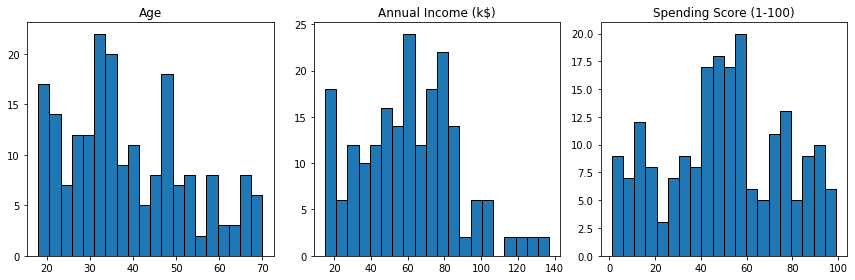

In [14]:
# 3. Exploratory Data Analysis
plt.figure(figsize=(12,4))
for i, col in enumerate(['Age','Annual Income (k$)','Spending Score (1-100)']):
    plt.subplot(1,3,i+1)
    plt.hist(df[col], bins=20, edgecolor='k')
    plt.title(col)
plt.tight_layout()
plt.show()


Means: [-0. -0. -0.]
Stds:  [1. 1. 1.]


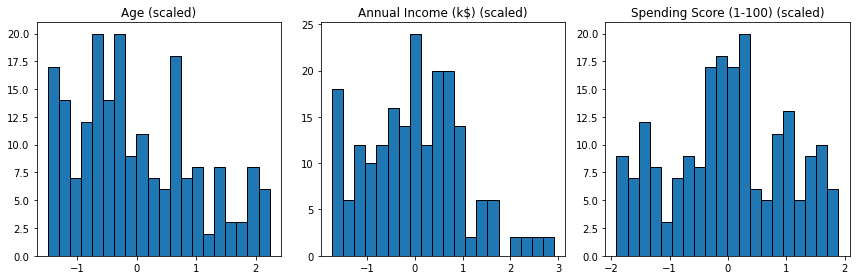

In [15]:
# 4. Preprocessing: select & scale features
features = ['Age','Annual Income (k$)','Spending Score (1-100)']
X = df[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# verify zero mean and unit variance
print("Means:", np.round(X_scaled.mean(axis=0),2))
print("Stds: ", np.round(X_scaled.std(axis=0),2))
plt.figure(figsize=(12,4))
for i, col in enumerate(features):
    plt.subplot(1,3,i+1)
    plt.hist(X_scaled[:,i], bins=20, edgecolor='k')
    plt.title(f"{col} (scaled)")
plt.tight_layout()
plt.show()


In [33]:
# 5. PCA projection (for plotting clusters later)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


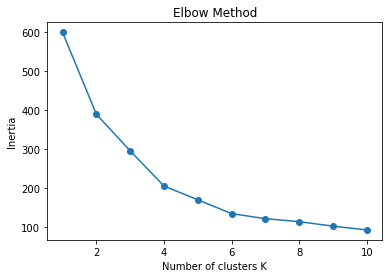

In [34]:
# 6. Elbow Method: inertia vs K
inertia = []
K_range = range(1,11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure()
plt.plot(K_range, inertia, 'o-')
plt.xlabel('Number of clusters K')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


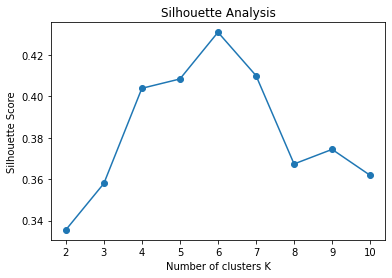

In [35]:
# 7. Silhouette Analysis: score vs K
sil_scores = []
K_range = range(2,11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure()
plt.plot(K_range, sil_scores, 'o-')
plt.xlabel('Number of clusters K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()


In [55]:
# 8. Final K-Means clustering (choose best_k from above, e.g. 4)
best_k = 5
km = KMeans(n_clusters=best_k, random_state=42)
df['Cluster'] = km.fit_predict(X_scaled)
df['PC1'], df['PC2'] = X_pca[:,0], X_pca[:,1]


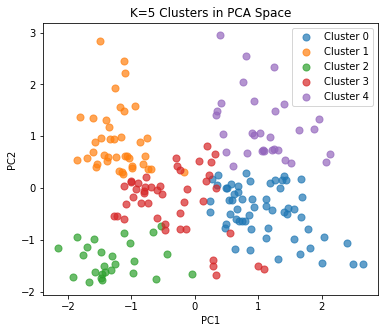

In [56]:
# 9. Visualize clusters in PCA space
plt.figure(figsize=(6,5))
for c in range(best_k):
    pts = df[df['Cluster']==c]
    plt.scatter(pts['PC1'], pts['PC2'], s=50, label=f'Cluster {c}', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title(f'K={best_k} Clusters in PCA Space')
plt.show()


In [57]:
# 10. Profile clusters in original feature space
centroids = scaler.inverse_transform(km.cluster_centers_)
profile = pd.DataFrame(centroids, columns=features)
profile['Cluster'] = range(best_k)
print(profile)


         Age  Annual Income (k$)  Spending Score (1-100)  Cluster
0  55.275862           47.620690               41.706897        0
1  32.875000           86.100000               81.525000        1
2  25.769231           26.115385               74.846154        2
3  26.733333           54.311111               40.911111        3
4  44.387097           89.774194               18.483871        4


In [60]:
# 1. Define your labels and interpretations
labels = {
    0: "Mature Moderate-Spenders",
    1: "Young Affluent Big Spenders",
    2: "Young Budget Eager Buyers",
    3: "Young Middlers",
    4: "Established Savers"
}

interpretations = {
    0: "Older customers with average income who spend somewhat below the overall average.",
    1: "Relatively young, high earners who spend a lot—your top-value customers.",
    2: "Young folks on lower incomes, yet with high engagement/spending score.",
    3: "Young adults with middle incomes but low–moderate spending.",
    4: "Older, high-income customers who spend very little relative to their peers."
}

# 2. Build the profile DataFrame
centroids = scaler.inverse_transform(km.cluster_centers_)
profile = pd.DataFrame(centroids, columns=features)
profile['Cluster'] = range(best_k)

# 3. Map in the labels and interpretations
profile['Label'] = profile['Cluster'].map(labels)
profile['Interpretation'] = profile['Cluster'].map(interpretations)

# 4. Display
print(profile)


         Age  Annual Income (k$)  Spending Score (1-100)  Cluster  \
0  55.275862           47.620690               41.706897        0   
1  32.875000           86.100000               81.525000        1   
2  25.769231           26.115385               74.846154        2   
3  26.733333           54.311111               40.911111        3   
4  44.387097           89.774194               18.483871        4   

                         Label  \
0     Mature Moderate-Spenders   
1  Young Affluent Big Spenders   
2    Young Budget Eager Buyers   
3               Young Middlers   
4           Established Savers   

                                      Interpretation  
0  Older customers with average income who spend ...  
1  Relatively young, high earners who spend a lot...  
2  Young folks on lower incomes, yet with high en...  
3  Young adults with middle incomes but low–moder...  
4  Older, high-income customers who spend very li...  
